In [2]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from random import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras import models, layers

def my_label(image_name):
    name = image_name.split('.')[-3]  # Extract the name from the image filename
    
    if name == 'Azzan':
        return np.array([1, 0, 0])  # One-hot encoding: [1, 0, 0] for Azzan, [0, 1, 0] for Rohan, [0, 0, 1] for Unknown
    elif name == 'Rohan':
        return np.array([0, 1, 0])  # One-hot encoding: [0, 1, 0] for Rohan, [1, 0, 0] for Azzan, [0, 0, 1] for Unknown
    elif name=='unknown':
        return np.array([0, 0, 1])  # One-hot encoding: [0, 0, 1] for Unknown, [1, 0, 0] for Azzan, [0, 1, 0] for Rohan

def preprocess_image(img):
    # Convert image to grayscale if it's not already
    if len(img.shape) > 2 and img.shape[2] == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Resize image to (50, 50)
    img = cv2.resize(img, (50, 50))
    return img

def my_data():
    data = []
    for img in tqdm(os.listdir(r"C:\Users\PMLS\Downloads\Face Recognition System\Face Recognition System\unknown")):
        path = os.path.join(r"C:\Users\PMLS\Downloads\Face Recognition System\Face Recognition System\unknown", img) 
        img_data = cv2.imread(path)  # Read image
        img_data = preprocess_image(img_data)  # Preprocess image
        label = my_label(img)  # Get the label for the image
        data.append((np.array(img_data), label))  # Store image-label pair as a tuple
    shuffle(data)
    return data

# Create the dataset
data = my_data()

# Split the dataset into train, validation, and test sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)

# Convert the data to numpy arrays
y_train = np.array([i[1] for i in train_data])

y_val = np.array([i[1] for i in val_data])

y_test = np.array([i[1] for i in test_data])
# Reshape the input data to match the model's input shape
x_train = np.array([i[0] for i in train_data]).reshape(-1, 50, 50)  # Reshape for ANN input
x_val = np.array([i[0] for i in val_data]).reshape(-1, 50, 50)  # Reshape for ANN input
x_test = np.array([i[0] for i in test_data]).reshape(-1, 50, 50)  # Reshape for ANN input
# Define the model
from tensorflow.keras import regularizers

# Define the model with dropout and L2 regularization
model = models.Sequential([
    layers.Flatten(input_shape=(50, 50)),
    layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',  # Use categorical cross-entropy for one-hot encoded labels
              metrics=['accuracy'])

# Train the model
history = model.fit(x_train, y_train,
                    epochs=500,
                    batch_size=32,  # Use a standard batch size
                    validation_data=(x_val, y_val))

# Display model summary
model.summary()


100%|████████████████████████████████████████████████████████████████████████████████| 236/236 [00:04<00:00, 48.72it/s]




Epoch 1/500


5/5 [==============================] - 2s 52ms/step - loss: 106.2244 - accuracy: 0.2933 - val_loss: 1.4530 - val_accuracy: 0.4737
Epoch 2/500
5/5 [==============================] - 0s 12ms/step - loss: 2.2019 - accuracy: 0.4800 - val_loss: 1.6910 - val_accuracy: 0.3947
Epoch 3/500
5/5 [==============================] - 0s 17ms/step - loss: 3.1536 - accuracy: 0.4733 - val_loss: 1.1689 - val_accuracy: 0.3947
Epoch 4/500
5/5 [==============================] - 0s 19ms/step - loss: 1.6154 - accuracy: 0.4667 - val_loss: 1.1864 - val_accuracy: 0.3947
Epoch 5/500
5/5 [==============================] - 0s 12ms/step - loss: 1.1731 - accuracy: 0.4467 - val_loss: 1.1825 - val_accuracy: 0.3947
Epoch 6/500
5/5 [==============================] - 0s 13ms/step - loss: 1.1767 - accuracy: 0.4933 - val_loss: 1.1788 - val_accuracy: 0.3947
Epoch 7/500
5/5 [==============================] - 0s 13ms/step - loss: 1.1702 - accuracy: 0.4267 - val_loss: 1.1754 - val_accuracy: 0.3947
Epoch 8/500
5/

1/1 [==============================] - 0s 16ms/step


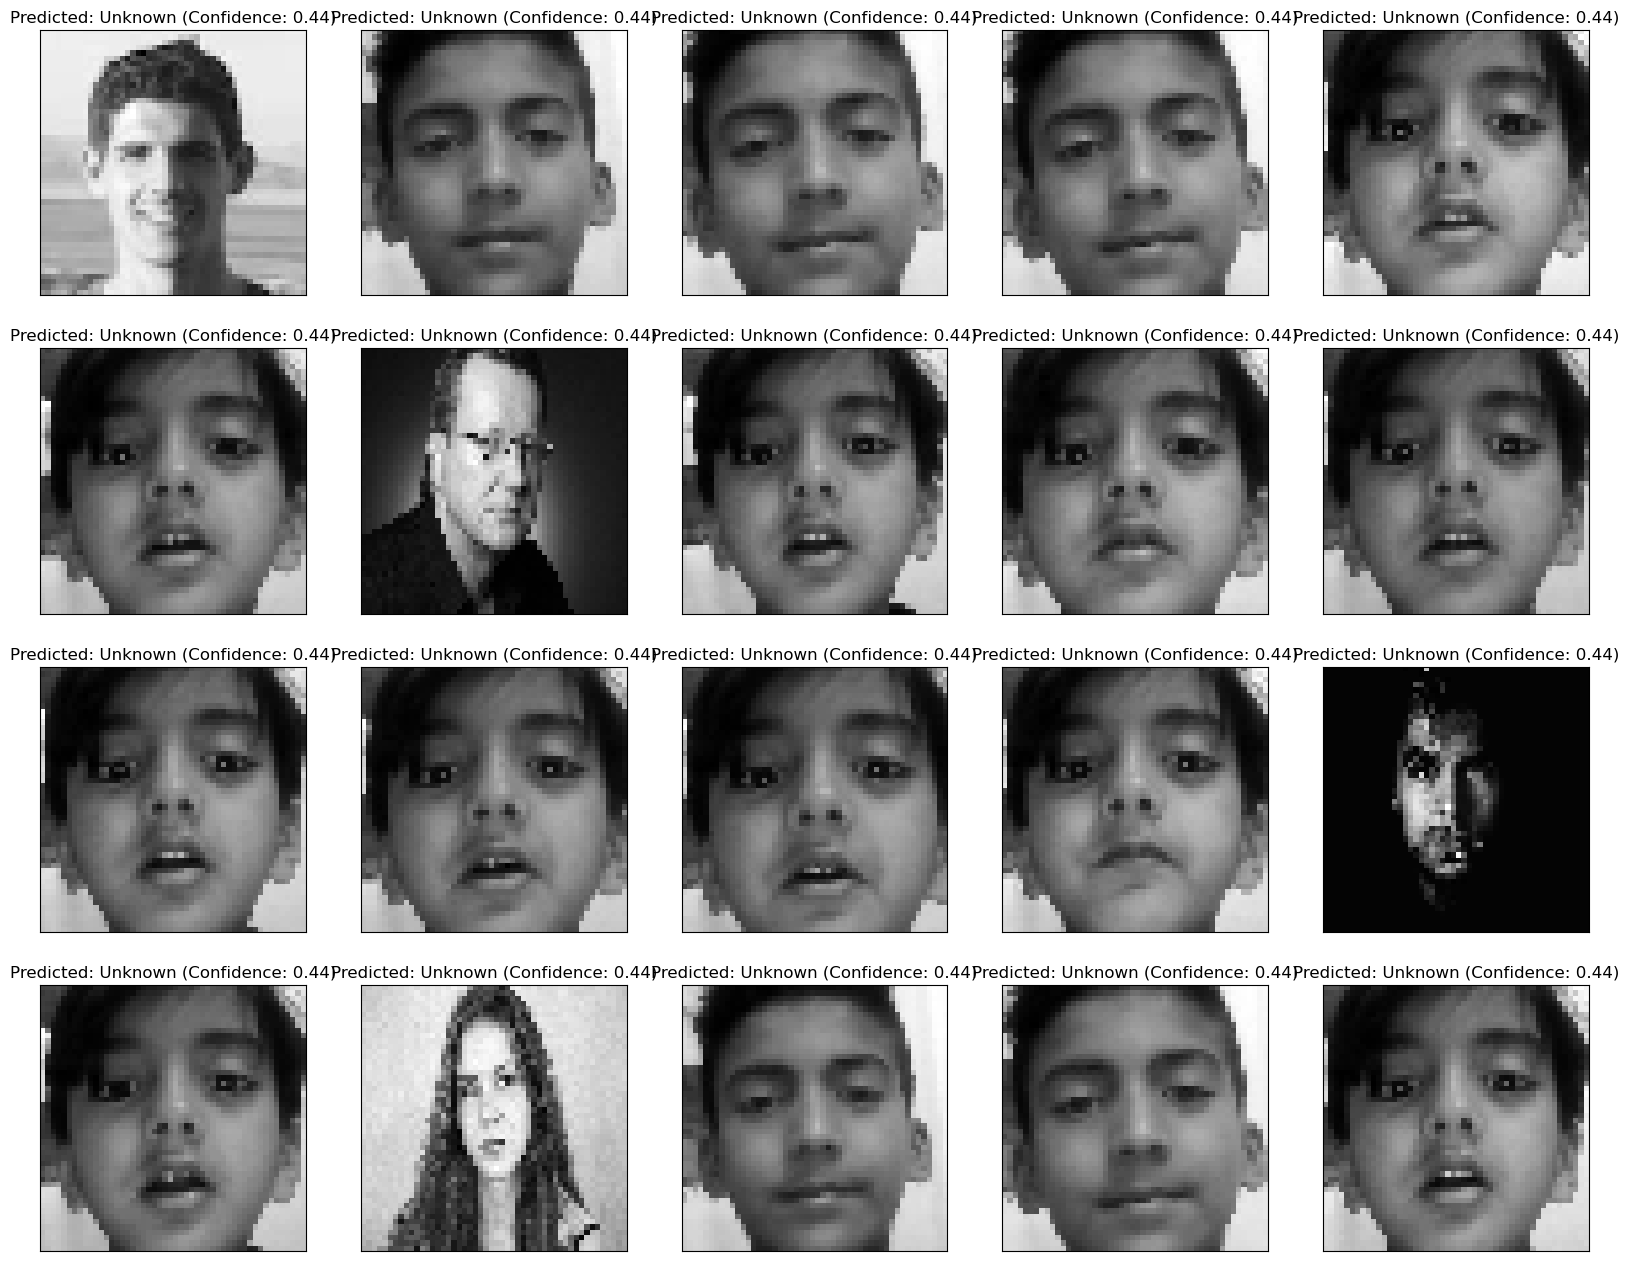

In [3]:
import matplotlib.pyplot as plt

# Define the confidence threshold for classification
confidence_threshold = 0.5

# Create lists to store confidence scores and predicted labels
confidence_scores = []
predicted_labels = []

# Create a figure for displaying images
fig = plt.figure(figsize=(20, 20))

# Iterate over the first 20 samples in the test data
for num, data in enumerate(test_data[:20]):
    img_data = data[0]
    y = fig.add_subplot(5, 5, num + 1)

    # Reshape the image data for prediction
    data = img_data.reshape(1, 50, 50)  # Reshape the data to match the model's input shape

    # Predict the label using the model
    model_out = model.predict(data)[0]

    # Determine the predicted label and confidence
    max_confidence = np.max(model_out)
    confidence_scores.append(max_confidence)
    predicted_label = np.argmax(model_out)
    if max_confidence >= confidence_threshold:
        if predicted_label == 0:
            my_label = 'Azzan'
        elif predicted_label == 1:
            my_label = 'Rohan'
        else:
            my_label = 'Unknown'
        predicted_labels.append(predicted_label)
    else:
        my_label = 'Unknown'
        predicted_labels.append(-1)
    
    # Display the image with its predicted label and confidence
    y.imshow(img_data, cmap='gray')
    plt.title(f"Predicted: {my_label} (Confidence: {max_confidence:.2f})")
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)

# Show the figure
plt.show()


In [1]:
import matplotlib.pyplot as plt

# Function to display random images from each class
def display_random_images(data, num_images=5):
    classes = ['Azzan', 'Rohan', 'Unknown']
    
    for class_idx in range(3):
        class_data = [item for item in data if np.argmax(item[1]) == class_idx]
        num_images = min(num_images, len(class_data))
        
        fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
        fig.suptitle(f"Random Images from Class: {classes[class_idx]}", fontsize=16)
        
        for i in range(num_images):
            img, label = class_data[i]
            axes[i].imshow(img, cmap='gray')
            axes[i].set_title(f"Image {i+1}")
            axes[i].axis('off')
            
        plt.show()

# Display random images from each class
display_random_images(data)

# Calculate and visualize class distribution
class_distribution = {'Azzan': 0, 'Rohan': 0, 'Unknown': 0}

for _, label in data:
    if np.array_equal(label, [1, 0, 0]):
        class_distribution['Azzan'] += 1
    elif np.array_equal(label, [0, 1, 0]):
        class_distribution['Rohan'] += 1
    elif np.array_equal(label, [0, 0, 1]):
        class_distribution['Unknown'] += 1

plt.bar(class_distribution.keys(), class_distribution.values())
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Class Distribution')
plt.show()


NameError: name 'data' is not defined

## Attempt

In [4]:
def my_label(image_name):
    name = image_name.split('.')[-3]  # Extract the name from the image filename
    
    if name == 'Azzan':
        return np.array([1, 0, 0])  # One-hot encoding: [1, 0, 0] for Azzan, [0, 1, 0] for Rohan, [0, 0, 1] for Unknown
    elif name == 'Rohan':
        return np.array([0, 1, 0])  # One-hot encoding: [0, 1, 0] for Rohan, [1, 0, 0] for Azzan, [0, 0, 1] for Unknown
    elif name=='unknown':
        return np.array([0, 0, 1])

In [5]:


def my_data():
    data = []
    for img in tqdm(os.listdir(r"C:\Users\PMLS\Downloads\Face Recognition System\Face Recognition System\unknown")):
        path = os.path.join(r"C:\Users\PMLS\Downloads\Face Recognition System\Face Recognition System\unknown", img) 
        img_data = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        img_data = cv2.resize(img_data, (50,50))
        label = my_label(img)  # Get the label for the image
        data.append((np.array(img_data), label))  # Store image-label pair as a tuple
    shuffle(data)
    return data


In [6]:
data=my_data()

100%|████████████████████████████████████████████████████████████████████████████████| 236/236 [00:02<00:00, 95.01it/s]


In [16]:
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)

# Convert the data to numpy arrays
x_train = np.array([i[0] for i in train_data]).reshape(-1, 50, 50, 1)  # Reshape for CNN input
y_train = np.array([i[1] for i in train_data])

x_val = np.array([i[0] for i in val_data]).reshape(-1, 50, 50, 1)  # Reshape for CNN input
y_val = np.array([i[1] for i in val_data])

x_test = np.array([i[0] for i in test_data]).reshape(-1, 50, 50, 1)  # Reshape for CNN input
y_test = np.array([i[1] for i in test_data])



In [17]:
x_val = np.array([i[0] for i in val_data])  # Get the image data from validation_data
x_val = x_val.reshape(-1, 50,50, 1)  # Reshape the image data to (batch_size, height, width, channels)
print("x_validation shape:", x_val.shape)

y_val = np.array([i[1] for i in val_data])  # Get the labels from validation_data
print("y_validation shape:", y_val.shape)


x_validation shape: (38, 50, 50, 1)
y_validation shape: (38, 3)


In [18]:
# Normalize pixel values to the range [0, 1]
x_train = x_train.astype('float32') / 255
x_val = x_val.astype('float32') / 255
x_test=x_test.astype('float')/255


In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an ImageDataGenerator instance for data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

# Fit the ImageDataGenerator to the training data
datagen.fit(x_train)

# Generate augmented data
augmented_data = datagen.flow(x_train, y_train, batch_size=32)


In [20]:
from tensorflow.keras import layers, models

def create_ann_model(input_shape, num_classes):
    model = models.Sequential([
        layers.Flatten(input_shape=input_shape),  # Flatten the input images
        layers.Dense(128, activation='relu'),     # Dense layer with 128 neurons and ReLU activation
        layers.Dense(64, activation='relu'),      # Dense layer with 64 neurons and ReLU activation
        layers.Dense(num_classes, activation='softmax')  # Output layer with num_classes neurons and softmax activation
    ])
    return model

# Example usage:
input_shape = (50, 50, 1)  # Assuming input images are resized to 50x50 grayscale images
num_classes = 3  # Number of classes (e.g., Azzan, Rohan, Unknown)
ann_model = create_ann_model(input_shape, num_classes)

# Compile the model
ann_model.compile(optimizer='adam',  # Optimizer: Adam
                  loss='categorical_crossentropy',  # Loss function: Categorical Crossentropy
                  metrics=['accuracy'])  # Evaluation metric: Accuracy

# Display the model summary
ann_model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 2500)              0         
                                                                 
 dense_6 (Dense)             (None, 128)               320128    
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                                 
 dense_8 (Dense)             (None, 3)                 195       
                                                                 
Total params: 328579 (1.25 MB)
Trainable params: 328579 (1.25 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [39]:
# Fit the model to the training data
history = ann_model.fit(augmented_data,
                              epochs=2000,  # Number of epochs
                              validation_data=(x_val, y_val),  # Validation data
                              batch_size=32)  # Batch size 


Epoch 1/2000
5/5 [==============================] - 0s 56ms/step - loss: 6.5214e-04 - accuracy: 1.0000 - val_loss: 0.9233 - val_accuracy: 0.9737
Epoch 2/2000
5/5 [==============================] - 0s 38ms/step - loss: 0.0124 - accuracy: 0.9933 - val_loss: 1.0754 - val_accuracy: 0.9737
Epoch 3/2000
5/5 [==============================] - 0s 41ms/step - loss: 0.0032 - accuracy: 1.0000 - val_loss: 1.2420 - val_accuracy: 0.9474
Epoch 4/2000
5/5 [==============================] - 0s 47ms/step - loss: 0.1050 - accuracy: 0.9800 - val_loss: 1.1094 - val_accuracy: 0.9737
Epoch 5/2000
5/5 [==============================] - 0s 39ms/step - loss: 0.0643 - accuracy: 0.9867 - val_loss: 0.7856 - val_accuracy: 0.9737
Epoch 6/2000
5/5 [==============================] - 0s 19ms/step - loss: 0.0107 - accuracy: 1.0000 - val_loss: 0.8571 - val_accuracy: 0.9474
Epoch 7/2000
5/5 [==============================] - 0s 19ms/step - loss: 0.0130 - accuracy: 0.9933 - val_loss: 1.1075 - val_accuracy: 0.9474
Epoch 8/2

1/1 [==============================] - 0s 16ms/step


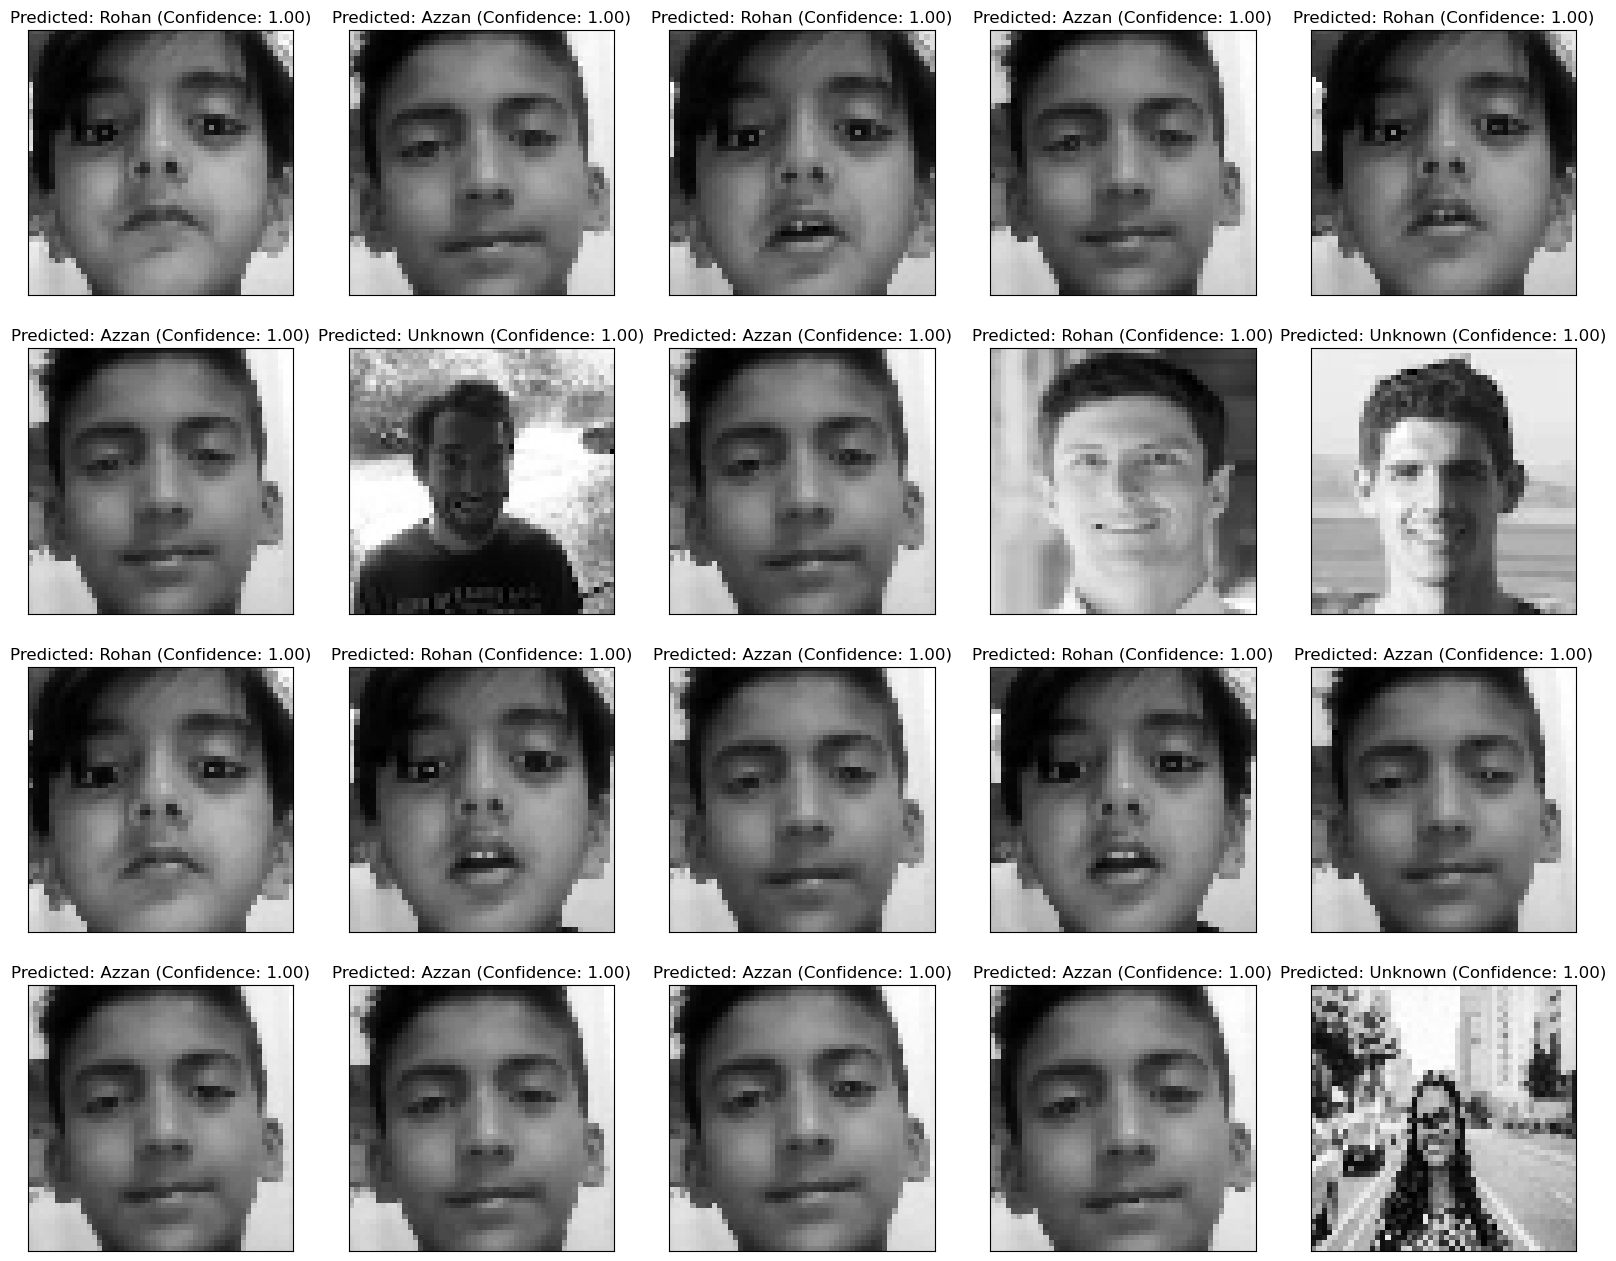

In [40]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have loaded the trained ANN model as ann_model

# Set the confidence threshold for classifying as "Unknown"
confidence_threshold = 0.5
predicted_labels = []

# Create a figure with a size of 20x20 inches
fig = plt.figure(figsize=(20, 20))
confidence_scores = []

# Iterate over the first 20 samples in the test data
for num, data in enumerate(test_data[:20]):
    img_data = data[0]
    y = fig.add_subplot(5, 5, num + 1)

    # Reshape the image data for prediction
    data = img_data.reshape(1, 50, 50, 1)

    # Predict the label using the model
    model_out = ann_model.predict(data)[0]

    # Determine the predicted label and confidence
    max_confidence = np.max(model_out)
    confidence_scores.append(max_confidence)
    predicted_label = np.argmax(model_out)
    if max_confidence >= confidence_threshold:
        if predicted_label == 0:
            my_label = 'Azzan'
        elif predicted_label == 1:
            my_label = 'Rohan'
        else:
            my_label = 'Unknown'
        predicted_labels.append(predicted_label)
    else:
        my_label = 'Unknown'
        predicted_labels.append(-1)

    # Display the image with its predicted label and confidence
    y.imshow(img_data, cmap='gray')
    plt.title(f"Predicted: {my_label} (Confidence: {max_confidence:.2f})")
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)

# Show the figure
plt.show()


In [37]:
ann_model.save('ann_model.h5')

In [ ]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model

facedetect = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

cap = cv2.VideoCapture(0)
cap.set(3, 640)
cap.set(4, 480)
font = cv2.FONT_HERSHEY_COMPLEX

model = load_model('ann_model.h5')

def get_className(classNo):
    if classNo == 0:
        return "Azzan"
    elif classNo == 1:
        return "Rohan"
    else:
        return "Unknown"

while True:
    success, imgOrignal = cap.read()
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    gray = cv2.cvtColor(imgOrignal, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    for x, y, w, h in faces:
        crop_img = imgOrignal[y:y+h, x:x+w]
        gray_img = cv2.cvtColor(crop_img, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
        resized_img = cv2.resize(gray_img, (50, 50))
        img = resized_img.reshape(1, 50, 50, 1)
        prediction = model.predict(img)
        classIndex = np.argmax(prediction)
        probabilityValue = prediction[0, classIndex]

        cv2.rectangle(imgOrignal, (x, y), (x+w, y+h), (0, 255, 0), 2)
        cv2.rectangle(imgOrignal, (x, y-40), (x+w, y), (0, 255, 0), -2)
        cv2.putText(imgOrignal, get_className(classIndex), (x, y-10), font, 0.75, (255, 255, 255), 1, cv2.LINE_AA)
        cv2.putText(imgOrignal, str(round(probabilityValue*100, 2))+"%", (180, 75), font, 0.75, (255, 0, 0), 2, cv2.LINE_AA)

    cv2.imshow("Result", imgOrignal)
    k = cv2.waitKey(1)
    if k == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()
